In [3]:
%matplotlib ipympl
from impedance.models.circuits.elements import element
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [4]:
@element(num_params=3, units=["Ohm", "F", ""],overwrite=True)
def TLMunix(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, Q, alpha = p[0], p[1], p[2]
    Z= 2*np.sqrt(R1/((omega*1j)**alpha*Q))*(1/(np.tanh(np.sqrt((1j*omega)**alpha*R1*Q))))
    return Z

C:\Users\admin\AppData\Local\Temp\ipykernel_7668\2283926456.py:5: RuntimeWarning: overflow encountered in tanh
  Z= 2*np.sqrt(R1/((omega*1j)**alpha*Q))*(1/(np.tanh(np.sqrt((1j*omega)**alpha*R1*Q))))


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4.9332672167393455e-18
       x: [ 1.000e+03  1.000e-03  1.000e+00]
     nit: 8
   direc: [[-1.239e+01 -1.252e-05  1.088e-03]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-5.201e-09 -2.013e-16 -1.035e-12]]
    nfev: 441
 allvecs: [array([ 5.000e+02,  1.000e-03,  9.000e-01]), array([ 5.963e+02,  1.007e-03,  9.183e-01]), array([ 1.020e+03,  1.020e-03,  9.981e-01]), array([ 1.012e+03,  1.012e-03,  9.988e-01]), array([ 1.000e+03,  1.000e-03,  1.000e+00]), array([ 1.000e+03,  1.000e-03,  1.000e+00]), array([ 1.000e+03,  1.000e-03,  1.000e+00]), array([ 1.000e+03,  1.000e-03,  1.000e+00]), array([ 1.000e+03,  1.000e-03,  1.000e+00])]


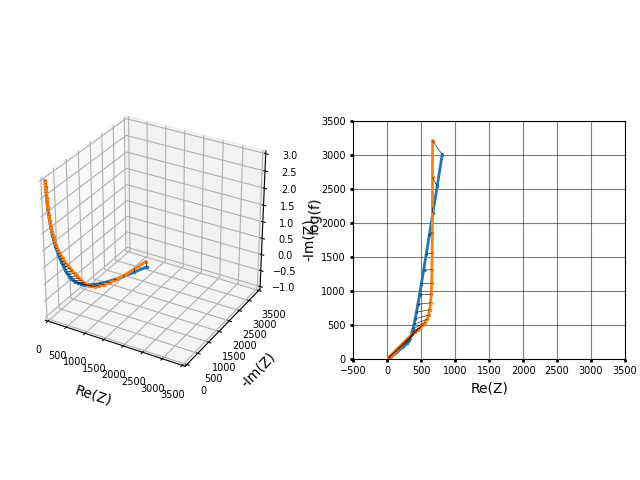

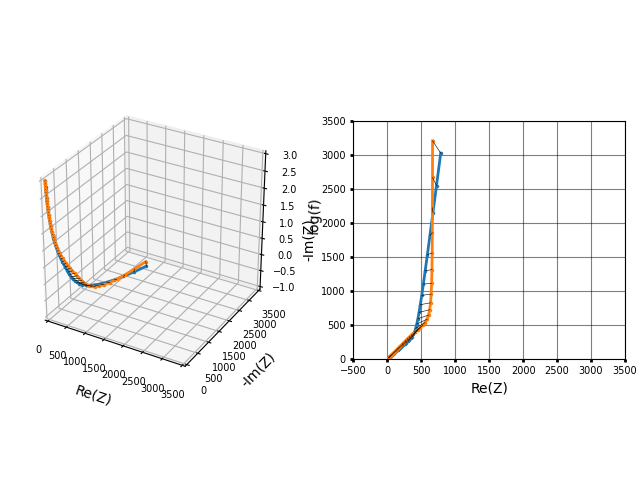

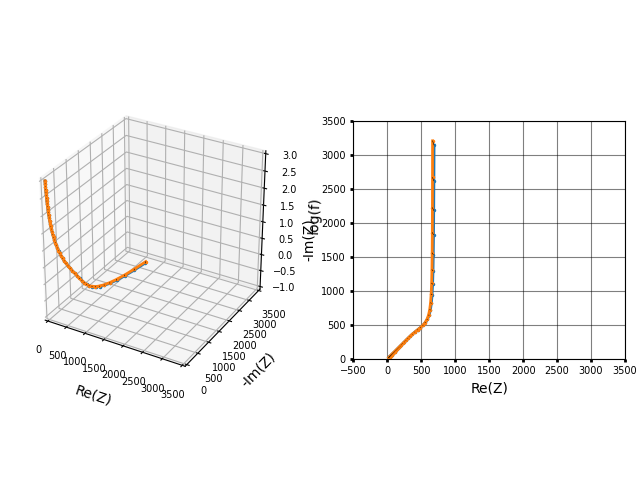

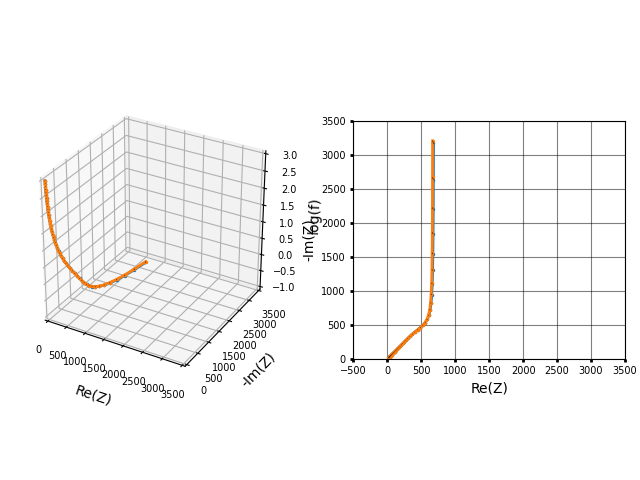

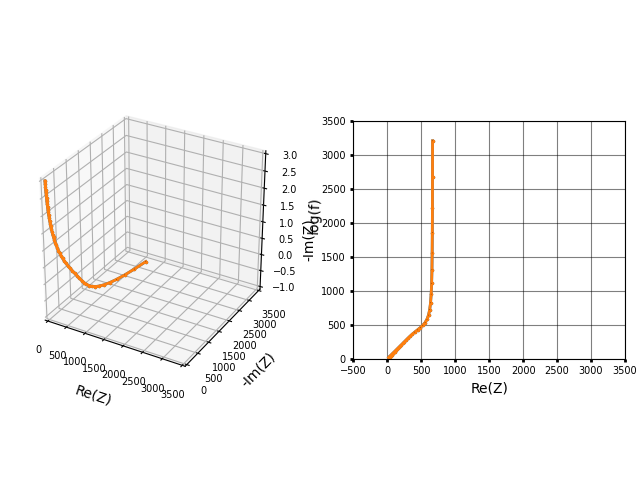

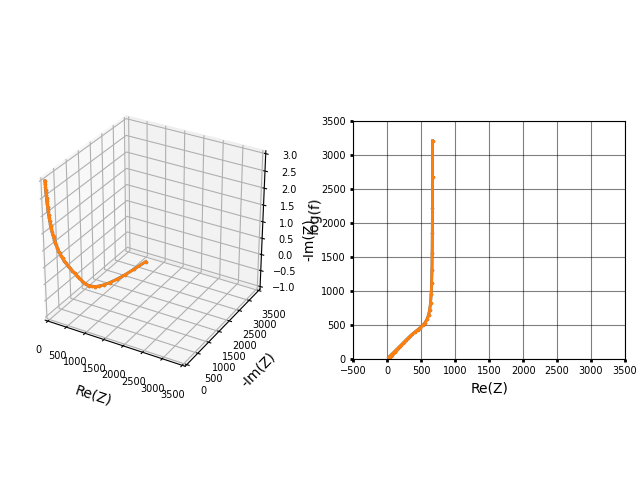

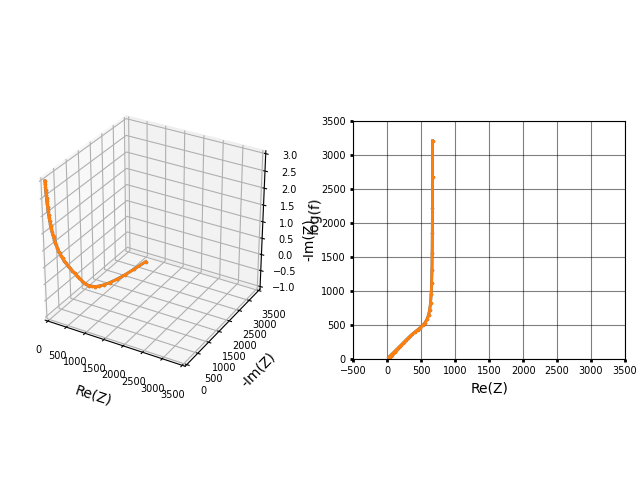

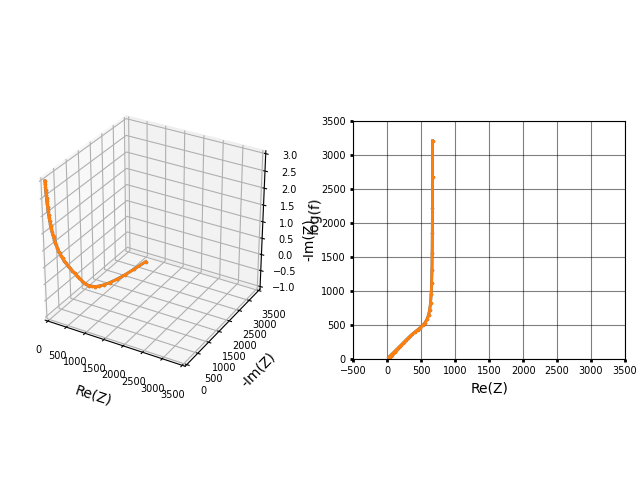

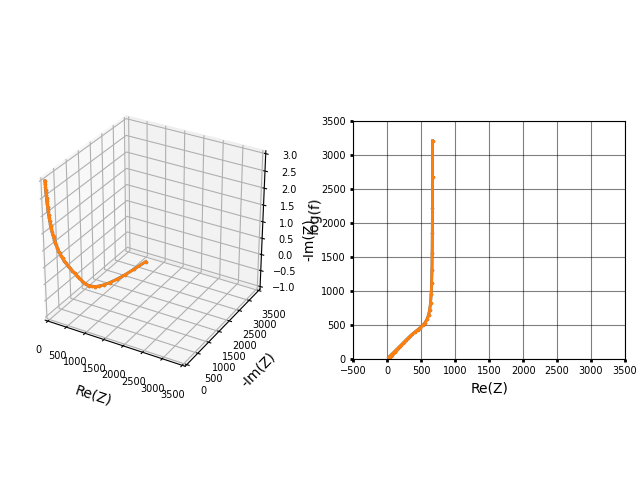

In [17]:
freq_list=np.logspace(-1,3,50)
circuit="TLMunix"
# c = CustomCircuit(initial_guess=[1],circuit=circuit,constants={"R_1":100,"CPE_1_0":1e-3})
# c = CustomCircuit(initial_guess=[1e-3,1],circuit=circuit,constants={"R_1":100})
c = CustomCircuit(initial_guess=[1000,1e-3,1],circuit=circuit)
z_exp=c.predict(frequencies=freq_list)

from scipy.optimize import minimize, least_squares


omega=2*np.pi*freq_list

def fun(params,omega,z_exp,weights):
    R=params[0]
    Q=params[1]
    alpha=params[2]
    # R0=100 
    # C0=1e-3
    # R0=1 
    # C0=1
    chi_total=0
    for w,z,wt in zip(omega,z_exp,weights):
        # c = CustomCircuit(initial_guess=[alpha],circuit=circuit,constants={"R_1":100,"CPE_1_0":1e-3})
        c = CustomCircuit(initial_guess=[R,Q,alpha],circuit=circuit)
        z_model=c.predict(frequencies=[w/(2*np.pi)])
        chi_real=(np.real(z_model)-np.real(z))**2/wt**2
        chi_imag=(np.imag(z_model)-np.imag(z))**2/wt**2
        chi_total+=(chi_real+chi_imag)

    return chi_total

## weighing ##
wt=np.abs(z_exp)
# wt=np.ones(len(z_exp))
# wt=omega

result=minimize(fun,(500,1e-3,0.9),args=(omega,z_exp,wt),method="Powell",options={'return_all': True})
print(result)

# result2=least_squares(fun,(100,2e-3),args=(omega,z_exp,wt))


# cc = CustomCircuit(initial_guess=[result.x[0],result.x[1]],circuit=circuitrq,constant={"R_1":100})
# z_fit = cc.predict(frequencies=freq_list)
# fig2, [axx1,axx2]=plt.subplots(1,2)
# xx=np.linspace(0.5,1,100)
# fun_val1=[]
# # print("Val of obj fun",fun([0.96],omega=omega,z_exp=z_exp,weights=wt))
# for x in xx:
#     fun_val1.append(fun([x],omega=omega,z_exp=z_exp,weights=np.abs(z_exp)))

# fun_val1=np.asarray(fun_val1)
# axx1.plot(xx,fun_val1,label="Mod wt")
# axx1.set_xlabel("α") 
# axx1.set_ylabel("fun")
# axx1.legend()

# fun_val2=[]
# for x in xx:
#     fun_val2.append(fun([x],omega=omega,z_exp=z_exp,weights=np.ones(len(z_exp))))
# axx2.plot(xx,fun_val2,label="Unit wt")
# axx2.set_xlabel("α")
# axx2.set_ylabel("fun")
# axx2.legend()
# fig2.tight_layout()


for sol in result.allvecs:
    # cc = CustomCircuit(initial_guess=[sol[0]],circuit=circuit,constants={"R_1":100,"CPE_1_0":1e-3})
    cc = CustomCircuit(initial_guess=[sol[0],sol[1],sol[2]],circuit=circuit)
    # cc = CustomCircuit(initial_guess=[sol[0],sol[1]],circuit=circuit,constants={"CPE_1_0":1e-3})
    z_fit = cc.predict(frequencies=freq_list)   
    fig=plt.figure()
    fig.add_gridspec(wspace=4)
    ax1=fig.add_subplot(121,projection="3d")
    ax1.tick_params(direction='out', length=6, width=2, colors='k',grid_color='k', grid_alpha=0.5,size=2,labelsize=7)
    ax2=fig.add_subplot(122)
    ax2.tick_params(direction='out', length=6, width=2, colors='k',grid_color='k', grid_alpha=0.5,size=2,labelsize=7)
    ax1.set_box_aspect([1,1,1])
    ax1.set_xlim(0,3500)
    ax1.set_ylim(0,3500)
    ax1.set_xlabel("Re(Z)")
    ax1.set_ylabel("-Im(Z)")
    ax1.set_zlabel("log(f)")
    ax2.set_xlim(-500,3500)
    ax2.set_ylim(0,3500)
    ax2.set_xlabel("Re(Z)")
    ax2.set_ylabel("-Im(Z)")
    ax2.set_aspect("equal")
    ax2.grid(True)
    #plot the 3D plot exp and model
    ax1.plot(np.real(z_fit),-np.imag(z_fit),np.log10(freq_list),".",ms=3,linestyle="-",label="Fit",linewidth=2)
    ax1.plot(np.real(z_exp),-np.imag(z_exp),np.log10(freq_list),".",ms=3,linestyle="-",label="Exp",linewidth=2)
    #plot the 2D plot exp vs model
    ax2.plot(np.real(z_fit),-np.imag(z_fit),".",ms=3,linestyle="-",label="Fit",linewidth=2)
    ax2.plot(np.real(z_exp),-np.imag(z_exp),".",ms=3,linestyle="-",label="Exp",linewidth=2)
    for p1,p2,f in zip(z_exp,z_fit,freq_list):
        ax1.plot([np.real(p1),np.real(p2)],[-np.imag(p1),-np.imag(p2)],[np.log10(f),np.log10(f)],color="black",linestyle="-",linewidth=0.4)
        ax2.plot([np.real(p1),np.real(p2)],[-np.imag(p1),-np.imag(p2)],color="black",linestyle="-",linewidth=0.4)
    plt.tight_layout()